# Tutorial on Intrinsic dimension estimation

In [24]:
import time
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from dadapy import data
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph


%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

# import a test set
X = np.random.multivariate_normal([0, 0], [[1, 0.9999],[ 0.9999, 1]], size = (2000,))


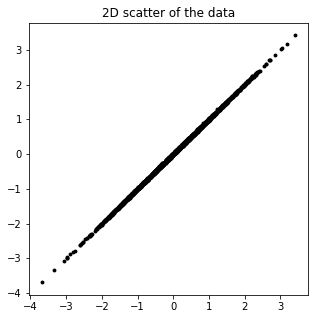

In [3]:
plt.figure(figsize = (5, 5))
plt.title('2D scatter of the data')
plt.scatter(X[:,0],X[:,1],s=15.,alpha=1.0,c='black',linewidths=0.0)
plt.show()

## TwoNN estimator

In [4]:
# initialise the Data class
_data = data.Data(X)

In [5]:
# estimate ID
_data.compute_id_2NN()


(2.031855667813603, 0.0, 0.008839730854191123)

In [6]:
#ids_scaling, ids_scaling_std, r2s_scaling = _data.return_id_scaling_2NN(N_min = 10)

<ErrorbarContainer object of 3 artists>

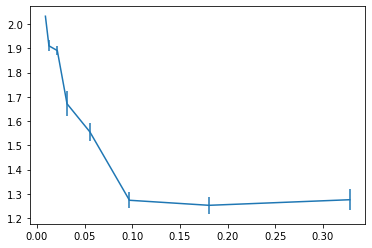

In [7]:
#plt.errorbar(r2s_scaling, ids_scaling, ids_scaling_std)

## Gride vs twoNN+decimation

In [59]:
X = np.load('datasets/isolet_float32.npy')
print(f'data shape: N data x P features = {X.shape}')
_data = data.Data(coordinates=X, 
                maxk=100)

data shape: N data x P features = (7797, 617)


In [51]:
start = time.time()
ids_scaling_gride, ids_scaling_err_gride, rs_scaling_gride = _data.return_id_scaling_gride(range_max=1024)
delay_gride = time.time()-start

start = time.time()
ids_scaling_twoNN, ids_scaling_err_twoNN, rs_scaling_twoNN = _data.return_id_scaling_2NN(N_min = 20)
delay_twoNN = time.time()-start

In [52]:
print(f'gride took {delay_gride: .2f} seconds')
print(f'twoNN took {delay_twoNN: .2f} seconds')

gride took  2.48 seconds
twoNN took  1.69 seconds


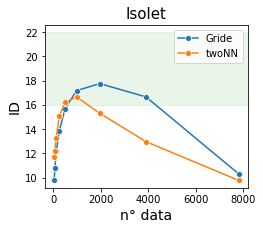

In [53]:
fig = plt.figure(figsize = (8, 3))
gs = GridSpec(1,2)
ax = fig.add_subplot(gs[0])

x = X.shape[0]/np.array([2**i for i in range(len(ids_scaling_gride))])
sns.lineplot(ax = ax, x=x, y = ids_scaling_gride, label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=x, y = ids_scaling_twoNN, label = 'twoNN', marker = 'o')
ax.legend(fontsize = 10)
#ax.set_xscale('log')
ax.set_title('Isolet', fontsize = 15)
ax.set_ylabel('ID', fontsize = 14)
ax.set_xlabel('n° data', fontsize = 14)
ax.axhspan(16, 22, color = 'C2', alpha = 0.1)

In [58]:
X = np.load('datasets/mnist.npy')
X = X.astype('float')
print(f'data shape: N data x P features = {X.shape}')
_data = data.Data(coordinates=X, 
                maxk=100)

data shape: N data x P features = (6742, 784)


In [55]:
start = time.time()
ids_scaling_gride, ids_scaling_err_gride, rs_scaling_gride = _data.return_id_scaling_gride(range_max=1024)
delay_gride = time.time()-start

start = time.time()
ids_scaling_twoNN, ids_scaling_err_twoNN, rs_scaling_twoNN = _data.return_id_scaling_2NN(N_min = 20)
delay_twoNN = time.time()-start

In [56]:
print(f'gride took {delay_gride: .2f} seconds')
print(f'twoNN took {delay_twoNN: .2f} seconds')

gride took  1.91 seconds
twoNN took  1.35 seconds


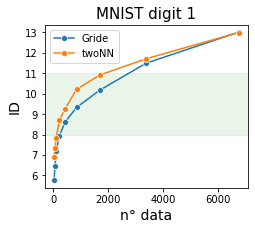

In [57]:
fig = plt.figure(figsize = (8, 3))
gs = GridSpec(1,2)
ax = fig.add_subplot(gs[0])

x = X.shape[0]/np.array([2**i for i in range(len(ids_scaling_gride))])
sns.lineplot(ax = ax, x=x, y = ids_scaling_gride, label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=x, y = ids_scaling_twoNN, label = 'twoNN', marker = 'o')
ax.legend(fontsize = 10)
#ax.set_xscale('log')
ax.set_title('MNIST digit 1', fontsize = 15)
ax.set_ylabel('ID', fontsize = 14)
ax.set_xlabel('n° data', fontsize = 14)
ax.axhspan(8, 11, color = 'C2', alpha = 0.1)